In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-colorblind')
import scipy.stats as sps
import networkx as nx
import time
from Dist_KL_UCB_Small_Graphs import Dist_KL_UCB
import os
from multiprocess import Pool

n_runs = 100
T = 10000
G1 = nx.complete_graph(6)
G2 = nx.cycle_graph([6,7,8,9,10,11])
G = nx.compose(G1,G2)
N = G.number_of_nodes()

nodes = list(G.nodes)
for i in nodes:
    G.add_edge(i,i)

rwd_means = [.2, .3, .4, .5, .6]
sigmas = [1, 1, 1, 0.01, 0.01, 0.01, 1, 1, 1, 0.01, 0.01, 0.01]
seeds = [i for i in range(n_runs)]

In [2]:
def worker(job_runs, seeds, sigmas, T, N, G):
    regrets_dist_kl_ucb = np.zeros((len(job_runs), N, T))
    for run in job_runs:
        start_run_t = time.time()
        
        sd = 0.1
        kl_distributions = [sps.truncnorm(a=(0-rwd_means[i])/sd, b=(1-rwd_means[i])/sd, loc=rwd_means[i], scale=sd) for i in range(len(rwd_means))]
        for i in range(len(rwd_means)):
            kl_distributions[i].random_state = np.random.RandomState(seed=seeds[run])
        distributions = [[sps.truncnorm(a=(0-rwd_means[i])/sd, b=(1-rwd_means[i])/sd, loc=rwd_means[i], scale=sd) for i in range(len(rwd_means))] for n in range(N)]
        for n in range(N):
            for i in range(len(rwd_means)):
                distributions[n][i].random_state = np.random.RandomState(seed=seeds[run])
        
        distkl = Dist_KL_UCB(T, distributions, G, sigma=sigmas)
        distkl.run()
        regrets_dist_kl_ucb[run-job_runs[0], :, :] = distkl.regrets
        
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return regrets_dist_kl_ucb

In [3]:
regrets_dist_kl_ucb = np.zeros((n_runs, N, T))
init_time = time.time()
cpus = os.cpu_count()
init_time = time.time()

pool = Pool()
jobs = list(range(n_runs))
job_size = n_runs // cpus
job_chunks = [(jobs[i:i + job_size], seeds, sigmas, T, N, G) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker, job_chunks)
pool.close()
pool.join()
regrets_dist_kl_ucb_unconcat = [result for result in results]
np.concatenate(regrets_dist_kl_ucb_unconcat, out=regrets_dist_kl_ucb)

end_run_t = time.time()

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_kl_ucb = np.mean(regrets_dist_kl_ucb, axis=0)
std_regrets_over_all_runs_dist_kl_ucb = np.std(regrets_dist_kl_ucb, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

/home/mulle/vip-mab/code/KL_UCB/Dist_KL_UCB_Small_Graphs.py:182: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_KL_UCB_Small_Graphs.py:182: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_KL_UCB_Small_Graphs.py:182: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_KL_UCB_Small_Graphs.py:182: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_KL_UCB_Small_Graphs.py:182: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(sel

finished run 0 in 95.04938530921936sec
finished run 24 in 95.27158713340759sec
finished run 72 in 97.38857340812683sec
finished run 56 in 97.90862107276917sec
finished run 40 in 97.97987699508667sec
finished run 16 in 98.17651510238647sec
finished run 8 in 98.62227535247803sec
finished run 80 in 98.7849109172821sec
finished run 88 in 99.07960772514343sec
finished run 32 in 99.6353051662445sec
finished run 64 in 99.92867970466614sec
finished run 48 in 101.43144845962524sec
finished run 25 in 100.34138870239258sec
finished run 41 in 101.0574197769165sec
finished run 1 in 104.07692551612854sec
finished run 9 in 101.07751107215881sec
finished run 73 in 103.13435673713684sec
finished run 65 in 100.89534664154053sec
finished run 89 in 102.21418809890747sec
finished run 17 in 103.762202501297sec
finished run 81 in 103.72437357902527sec
finished run 33 in 102.89866328239441sec
finished run 57 in 104.85578870773315sec
finished run 49 in 104.87835645675659sec
finished run 26 in 99.3976583480835s

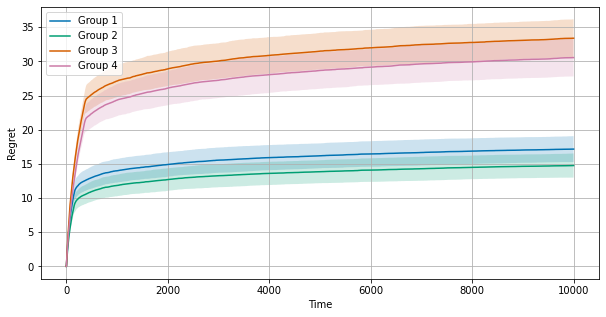

In [4]:
plt.figure(figsize=(10,5))

avg_3_1_regret = np.mean(mean_regrets_over_all_runs_dist_kl_ucb[0:3], axis=0)
avg_3_001_regret = np.mean(mean_regrets_over_all_runs_dist_kl_ucb[3:6], axis=0)
avg_6_1_regret = np.mean(mean_regrets_over_all_runs_dist_kl_ucb[6:9], axis=0)
avg_6_001_regret = np.mean(mean_regrets_over_all_runs_dist_kl_ucb[9:12], axis=0)
std_3_1_regret = np.mean(std_regrets_over_all_runs_dist_kl_ucb[0:3], axis=0)
std_3_001_regret = np.mean(std_regrets_over_all_runs_dist_kl_ucb[3:6], axis=0)
std_6_1_regret = np.mean(std_regrets_over_all_runs_dist_kl_ucb[6:9], axis=0)
std_6_001_regret = np.mean(std_regrets_over_all_runs_dist_kl_ucb[9:12], axis=0)

plt.plot(time_axis, avg_3_1_regret, label="Group 1")
plt.fill_between(time_axis, avg_3_1_regret-std_3_1_regret, avg_3_1_regret+std_3_1_regret,alpha=.2)
plt.plot(time_axis, avg_3_001_regret, label="Group 2")
plt.fill_between(time_axis, avg_3_001_regret-std_3_001_regret, avg_3_001_regret+std_3_001_regret,alpha=.2)
plt.plot(time_axis, avg_6_1_regret, label="Group 3")
plt.fill_between(time_axis, avg_6_1_regret-std_6_1_regret, avg_6_1_regret+std_6_1_regret,alpha=.2)
plt.plot(time_axis, avg_6_001_regret, label="Group 4")
plt.fill_between(time_axis, avg_6_001_regret-std_6_001_regret, avg_6_001_regret+std_6_001_regret,alpha=.2)
plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend()
plt.grid()

plt.savefig("dist_KL_UCB_small_graphs_all_together_N12.pdf", bbox_inches='tight')